In [15]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import pandas as pd

In [16]:
# Generate some random data
# 20 samples, 5 features
train_X = np.random.uniform(low = 0, high = 10, size = (20,5))
df = pd.DataFrame(train_X, columns=['pH','c1','c2', 'c4', 'c5'])
df

,pH,c1,c2,c4,c5
0,8.933520,2.202306,1.252165,0.659583,6.375790
1,4.215507,3.273126,4.176103,3.706245,5.239943
2,5.720708,0.794855,6.122228,3.250749,4.714770
3,6.725635,0.313228,8.709737,2.135359,7.898439
4,4.988285,1.280033,7.839792,0.487485,9.239003
5,2.248734,5.271689,3.215468,2.099299,5.600518
6,4.957401,9.193630,7.795078,5.083029,6.572145
7,3.556086,3.896913,4.091505,8.833141,3.855382
8,9.999067,1.793920,0.820312,9.750646,3.769133
9,1.206264,6.782149,3.356041,2.257167,9.179899


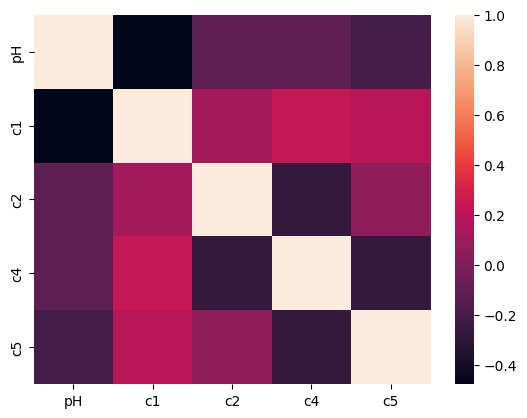

In [17]:
xmean = df.mean()
xstd = df.std()
Z = (df - xmean) / xstd

c = Z.cov()
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(c)
plt.show()

In [18]:
eigenvalues, eigenvectors = np.linalg.eig(c)
print(eigenvalues)

explained_var = np.cumsum(eigenvalues) / np.sum(eigenvalues)
explained_var

n_components = np.argmax(explained_var >= 0.50) + 1
n_components

[1.66522915 1.40410771 0.4390867  0.5520981  0.93947834]


np.int64(2)

Explained variance ratio: [12.20242154 10.45718203]
Explained variance ratio: [0.33129676 0.28391336]


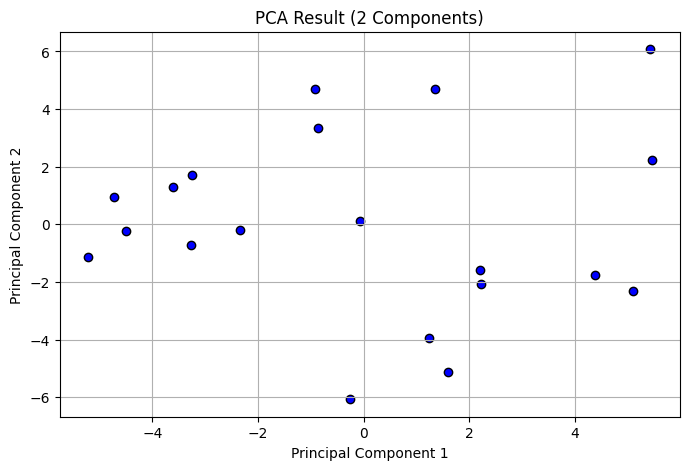

In [21]:
# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df)

# Create a DataFrame with the PCA result
#print(pca_result)

# Explained variance measures the absolute amount of variance that is explained by each principal component. 
# This is useful when you want to know how many principal components you need to retain in order to capture a 
# certain percentage of the total variance in the original dataset.
print("Explained variance ratio:", pca.explained_variance_)

# Explained variance ratio measures the relative amount of variance that is explained by each principal component. 
# This is useful when you want to know how much information each principal component
# contributes to the overall structure of the data.
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Plot the PCA result
plt.figure(figsize=(8, 5))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', edgecolor='k')
plt.title('PCA Result (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

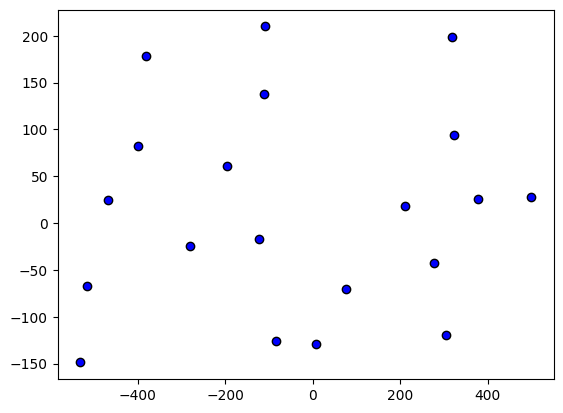

In [23]:
#TSNE
tsne = TSNE(n_components=2, perplexity=5, learning_rate=200, random_state=42)
tsne_result = tsne.fit_transform(df)
#plt.plot(tsne_result)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='blue', edgecolor='k')

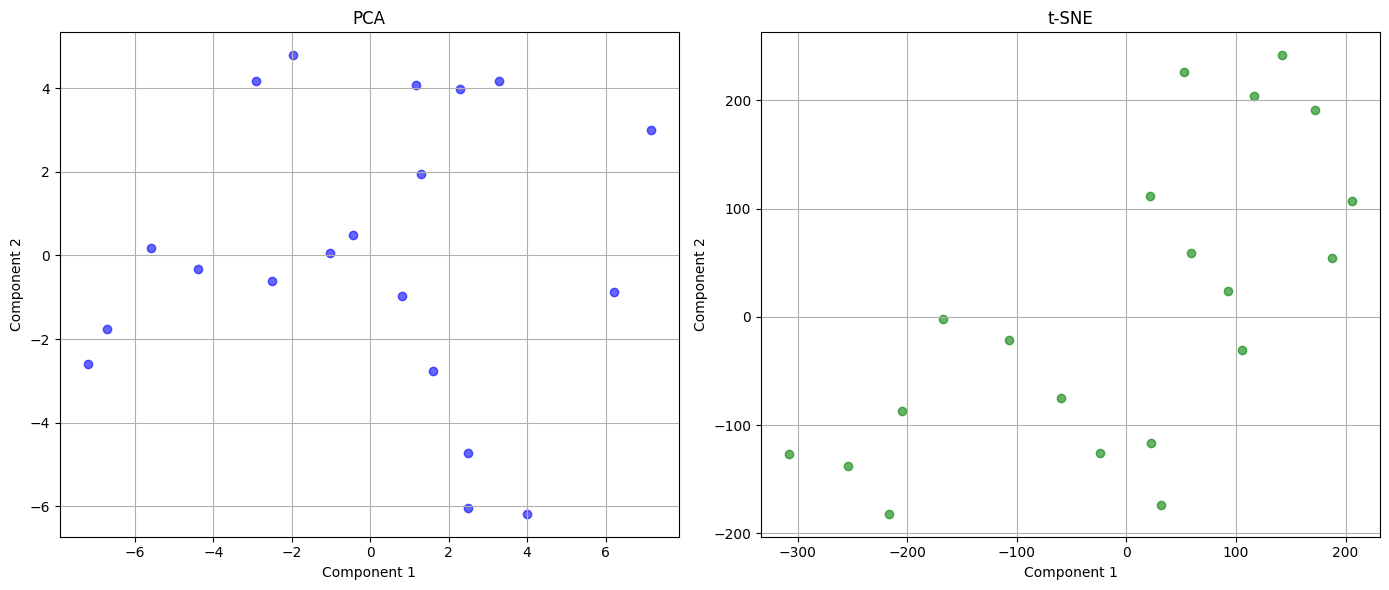

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PCA plot
axes[0].scatter(pca_result[:, 0], pca_result[:, 1], c='blue', alpha=0.6)
axes[0].set_title('PCA')

# t-SNE plot
axes[1].scatter(tsne_result[:, 0], tsne_result[:, 1], c='green', alpha=0.6)
axes[1].set_title('t-SNE')

for ax in axes:
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import umap.umap_ as umap

# data is your high-dimensional input, e.g., shape (20, 5)
umapp = umap.UMAP(n_components=2, random_state=42)
umap_result = umapp.fit_transform(df)


c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


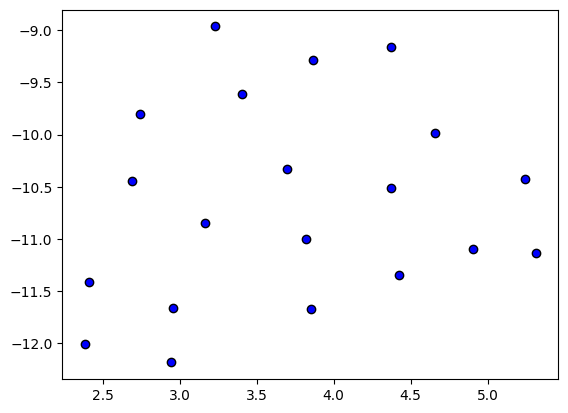

In [ ]:
plt.scatter(umap_result[:, 0], umap_result[:, 1], c='blue', edgecolor='k')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [ ]:
d = df.data  
l = df.target  

df = pd.DataFrame(d)
df['label'] = l  

print(df.head(4))